In [1]:
# import pandas as pd
import pandas as pd
from glob import glob
import os
import re
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

In [2]:
all_data = pd.read_csv('drive/MyDrive/DATA3001/datascience-cis-2022.csv')
all_data['time'] = pd.to_datetime(all_data['time'])
all_data = all_data.set_index('time','device_mac')
all_data.index = all_data.index.round('min')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.set_index except for the argument 'keys' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


In [3]:
for col in all_data.columns:
    if (all_data[col] == 0).all():
        print(col)
# drop these cols

all_data = all_data.loc[:, (all_data != 0).any(axis=0)]

FromInternetTCPPort443IPurn:ietf:params:mud:controllerByteCount
FromInternetTCPPort443IPurn:ietf:params:mud:controllerPacketCount
ToInternetTCPPort443IPurn:ietf:params:mud:controllerByteCount
ToInternetTCPPort443IPurn:ietf:params:mud:controllerPacketCount


In [4]:
def nonzero_proportion(x):
    return (x!=0).mean()

In [5]:
import numpy as np
numeric_cols = list(all_data.columns)[:-1]
funcs = {'mean':np.mean, 'std':np.std, 'max':np.max, 'min':np.min, 'nonzero_p':nonzero_proportion}

In [6]:
all_data['time_group'] = all_data.index.to_period('H').strftime('%d_%H')

In [7]:
all_data['id'] = all_data['device_mac']+'_'+all_data['time_group']

In [8]:
summary = {key: [] for key in funcs.keys()}
summary['info'] = []
summary['target'] = []

In [9]:
from tqdm import tqdm

In [10]:
df = all_data

In [11]:
for i in pd.Series(df['time_group'].unique()).sample(10,random_state=42):
  print(i)

03_22
08_19
04_09
03_01
06_17
10_06
06_12
04_15
12_09
15_14


In [12]:
for time_slice in tqdm(pd.Series(df['time_group'].unique()).sample(15,random_state=42)):
    for device in tqdm(pd.Series(df['device_mac'].unique()).sample(200)):
        tmp = df.loc[(df['time_group']==time_slice)&(df['device_mac']==device)][numeric_cols]
        for col in (tmp.columns):
            for k in funcs.keys():
                summary[k].append(funcs[k](tmp[col]))
            summary['info'].append(device+'_'+time_slice)
            summary['target'].append(col)

100%|██████████| 15/15 [1:43:47<00:00, 415.14s/it]


In [13]:
t = pd.DataFrame(summary) 

In [14]:
t.loc[t['nonzero_p']!=0].to_csv('drive/MyDrive/DATA3001/hourly_transformed_large.csv',index=False)

In [ ]:
for col in all_data.columns:
    if (all_data[col] == 0).all():
        print(col)
# drop these cols

all_data = all_data.loc[:, (all_data != 0).any(axis=0)]

FromInternetTCPPort443IPurn:ietf:params:mud:controllerByteCount
FromInternetTCPPort443IPurn:ietf:params:mud:controllerPacketCount
ToInternetTCPPort443IPurn:ietf:params:mud:controllerByteCount
ToInternetTCPPort443IPurn:ietf:params:mud:controllerPacketCount


In [ ]:
def nonzero_proportion(x):
    return (x!=0).mean()

In [ ]:
all_data['time_group'] = all_data.index.to_period('H').strftime('%d_%H')

In [ ]:
all_data['id'] = all_data['device_mac']+'_'+all_data['time_group']

In [ ]:
ids = pd.Series(all_data['id'].unique()).sample(1000)

In [ ]:
train_ids, test_ids = ids[:700], ids[700:]

In [ ]:
all_data = all_data.loc[all_data['id'].isin(ids)]

In [ ]:
for col in all_data.columns:
  if nonzero_proportion(all_data[col]) < 0.00001:
    all_data = all_data.drop(columns=col)

In [ ]:
#!mkdir train
#!mkdir test
# !rm train/*
# !rm test/*

In [ ]:
#!pip install tsfresh

In [ ]:
from tqdm import tqdm
from tsfresh.feature_extraction import extract_features, EfficientFCParameters

ERROR:numba.cuda.cudadrv.driver:Call to cuInit results in CUDA_ERROR_NO_DEVICE


In [ ]:
for device_id in tqdm(train_ids):
    # df.drop(columns=['device_mac','time_group']).reset_index().set_index('id').T.unstack(level=1)
    tmp = all_data.drop(columns=['device_mac','time_group']).reset_index().set_index(['time','id']).stack().reset_index()

    tmp = tmp.loc[tmp['id']==device_id]

    tmp['row_id'] = tmp['time'].astype(str) + '|' + tmp['level_2']

    tmp = tmp.drop(columns=['time','level_2']).pivot(columns='id',values=0,index='row_id').reset_index()

    tmp[['time','network']] = tmp.apply(lambda x: x['row_id'].split('|'),result_type='expand',axis=1)

    tmp = tmp.drop(columns='row_id').set_index(['time','network']).fillna(0).reset_index()

    if (nonzero_proportion(tmp[device_id]) == 0):
      continue

    extracted_features = extract_features(tmp, column_id="network", column_sort="time", default_fc_parameters=EfficientFCParameters()).reset_index()

    extracted_features.to_csv(f'train/{device_id.replace(":",".")}.csv',index=False)

In [ ]:
for device_id in tqdm(test_ids):
    # df.drop(columns=['device_mac','time_group']).reset_index().set_index('id').T.unstack(level=1)
    tmp = all_data.drop(columns=['device_mac','time_group']).reset_index().set_index(['time','id']).stack().reset_index()

    tmp = tmp.loc[tmp['id']==device_id]

    tmp['row_id'] = tmp['time'].astype(str) + '|' + tmp['level_2']

    tmp = tmp.drop(columns=['time','level_2']).pivot(columns='id',values=0,index='row_id').reset_index()

    tmp[['time','network']] = tmp.apply(lambda x: x['row_id'].split('|'),result_type='expand',axis=1)

    tmp = tmp.drop(columns='row_id').set_index(['time','network']).fillna(0).reset_index()

    print(nonzero_proportion(tmp[device_id]))

    extracted_features = extract_features(tmp, column_id="network", column_sort="time", default_fc_parameters=EfficientFCParameters()).reset_index()

    extracted_features.to_csv(f'test/{device_id.replace(":",".")}.csv',index=False)

In [14]:
train = pd.concat([pd.read_csv(x).rename(columns=lambda x: re.sub(r'^([a-z0-9]*:){3}[a-z0-9]*_\d\d_\d\d__','',x)) for x in glob('drive/MyDrive/DATA3001/train/*')])
test = pd.concat([pd.read_csv(x).rename(columns=lambda x: re.sub(r'^([a-z0-9]*:){3}[a-z0-9]*_\d\d_\d\d__','',x)) for x in glob('drive/MyDrive/DATA3001/test/*')])

In [15]:
train.to_csv('drive/MyDrive/DATA3001/tsfresh_train.csv')
test.to_csv('drive/MyDrive/DATA3001/tsfresh_test.csv')

In [3]:
X_train, y_train, X_test, y_test = train.drop(columns=['index']), train['index'], test.drop(columns=['index']), test['index']

In [50]:
# X_train = X_train[cols]
# X_test = X_test[cols]

In [4]:
clf = XGBClassifier()

In [5]:
clf.fit(X_train, y_train)

XGBClassifier(objective='multi:softprob')

In [6]:
y_pred = clf.predict(X_test)

In [ ]:
# print('Using minimal columns')
# print(classification_report(y_test, y_pred))

In [7]:
print('All columns')
print(classification_report(y_test, y_pred))

All columns
                                                                   precision    recall  f1-score   support

  FromInternetTCPPort554IPurn:ietf:params:mud:controllerByteCount       0.97      0.11      0.19       300
FromInternetTCPPort554IPurn:ietf:params:mud:controllerPacketCount       0.55      0.08      0.14       300
   FromInternetTCPPort80IPurn:ietf:params:mud:controllerByteCount       0.91      0.57      0.70       300
 FromInternetTCPPort80IPurn:ietf:params:mud:controllerPacketCount       0.85      0.53      0.66       300
   FromInternetUDPPort67IPurn:ietf:params:mud:controllerByteCount       0.99      0.95      0.97       300
 FromInternetUDPPort67IPurn:ietf:params:mud:controllerPacketCount       0.99      0.95      0.97       300
   ToInternetRSVPPortAllIPurn:ietf:params:mud:controllerByteCount       0.95      0.80      0.87       300
 ToInternetRSVPPortAllIPurn:ietf:params:mud:controllerPacketCount       0.98      0.81      0.89       300
    ToInternetTCPPort554

In [10]:
def evaluate_classifier(clf, X, y):
  y_pred = clf.predict(X)
  probabilities = clf.predict_proba(X)
  roc_auc = roc_auc_score(y, probabilities, average='weighted', multi_class='ovr')
  f1score = f1_score(y,y_pred, average='weighted')
  print(f'ROC-AUC (One vs Rest) = {roc_auc}')
  print(f'Weighted F1-score = {f1score}')

In [9]:
from sklearn.metrics import roc_auc_score, f1_score

In [11]:
evaluate_classifier(clf, X_test, y_test)

ROC-AUC (One vs Rest) = 0.9092431944444445
Weighted F1-score = 0.638128176522666


In [35]:
# !cp -r test drive/MyDrive/DATA3001/
# !cp -r train drive/MyDrive/DATA3001/

In [36]:
import matplotlib.pyplot as plt

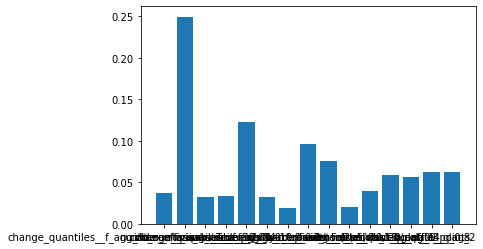

In [57]:
# plot
plt.bar(X_train.columns, clf.feature_importances_)
plt.show()

In [38]:
from xgboost import plot_importance

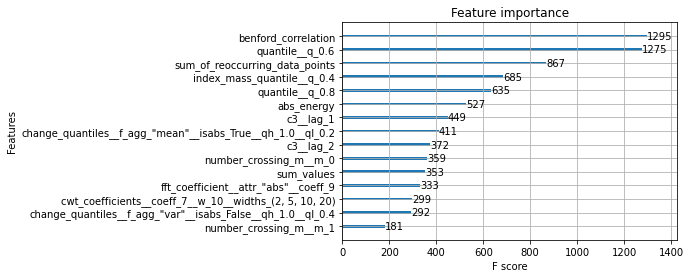

In [58]:
plot_importance(clf)

In [47]:
cols = [x[0] for x in sorted(zip(X_train.columns, clf.feature_importances_),key=lambda x: x[1], reverse=True)[:15]]

In [15]:
from sklearn.model_selection import train_test_split

In [23]:
transformed_data = pd.read_csv('drive/MyDrive/DATA3001/transformed_data.csv').drop(columns=['info'])
X_train, X_test, y_train, y_test = train_test_split(transformed_data.drop(columns=['target']), transformed_data['target'])

In [25]:
y_pred = XGBClassifier().fit(X_train, y_train).predict(X_test)

In [26]:
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                                                   precision    recall  f1-score   support

  FromInternetTCPPort554IPurn:ietf:params:mud:controllerByteCount       0.98      0.24      0.39       499
FromInternetTCPPort554IPurn:ietf:params:mud:controllerPacketCount       0.99      0.24      0.38       488
   FromInternetTCPPort80IPurn:ietf:params:mud:controllerByteCount       0.99      0.65      0.78       529
 FromInternetTCPPort80IPurn:ietf:params:mud:controllerPacketCount       0.98      0.62      0.75       515
   FromInternetUDPPort67IPurn:ietf:params:mud:controllerByteCount       1.00      1.00      1.00       488
 FromInternetUDPPort67IPurn:ietf:params:mud:controllerPacketCount       1.00      1.00      1.00       477
   ToInternetRSVPPortAllIPurn:ietf:params:mud:controllerByteCount       1.00      1.00      1.00       480
 ToInternetRSVPPortAllIPurn:ietf:params:mud:controllerPacketCount       1.00      1.00      1.00       522
    ToInternetTCPPort554IPurn:ietf:p

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
X_train.columns